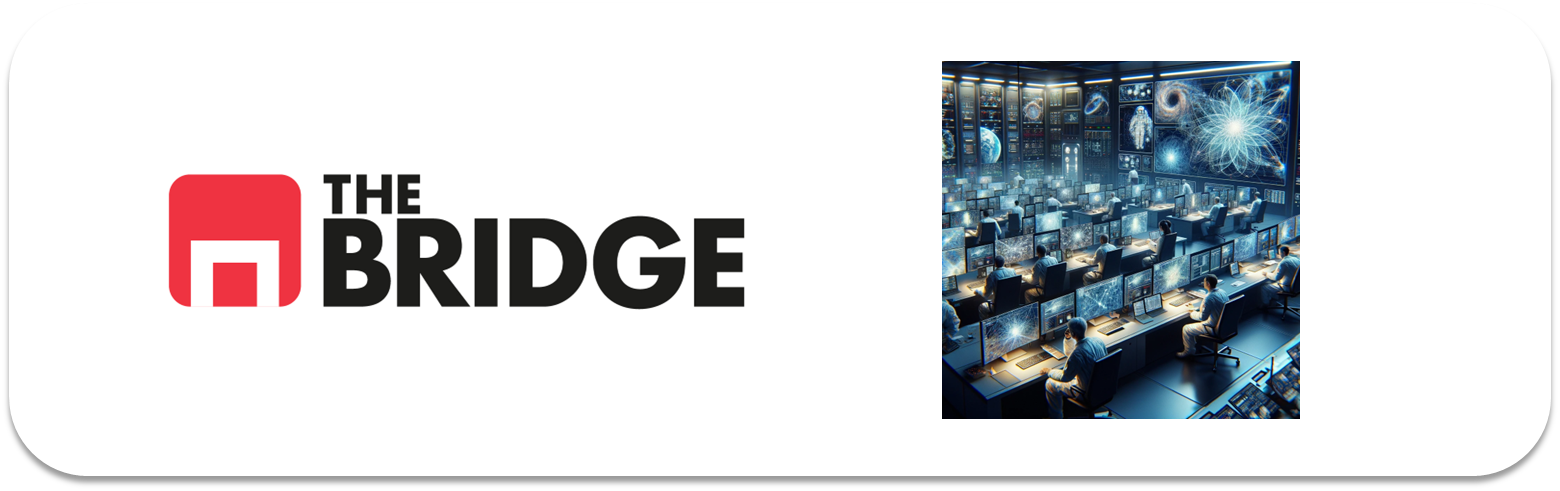

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [11]:
# Paquetes de visualización y análisis de datos
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# Gestión de advertencias para evitar mensajes innecesarios
import warnings
warnings.filterwarnings('ignore')

# Funciones de scikit-learn para métricas y división de datos
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Módulos para manejo de archivos y procesamiento de imágenes
import os
import glob
from PIL import Image

# Deep Learning: TensorFlow y Keras para construir y entrenar la red neuronal
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Parámetros de la imagen
img_height, img_width = 224, 224  
batch_size = 32

# Rutas a los conjuntos de datos
train_dir = "data/seg_train"
test_dir = "data/seg_test"
pred_dir = "data/seg_pred"  # Nota: Para predicción, las imágenes no están en subcarpetas


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creamos un generador para entrenamiento con data augmentation y separación para validación
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Escalado de píxeles
    validation_split=0.2,    # Reservamos el 20% de los datos para validación
    horizontal_flip=True,    # Volteo horizontal aleatorio
    zoom_range=0.2           # Zoom aleatorio
)


In [14]:
# Generador para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',   # Usa el 80% de los datos para entrenamiento
    shuffle=True
)

# Generador para el conjunto de validación
validation_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Usa el 20% de los datos para validación
    shuffle=True
)

# Mostrar las clases que se han detectado y su mapeo
print("Clases encontradas en entrenamiento:", train_generator.class_indices)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Clases encontradas en entrenamiento: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


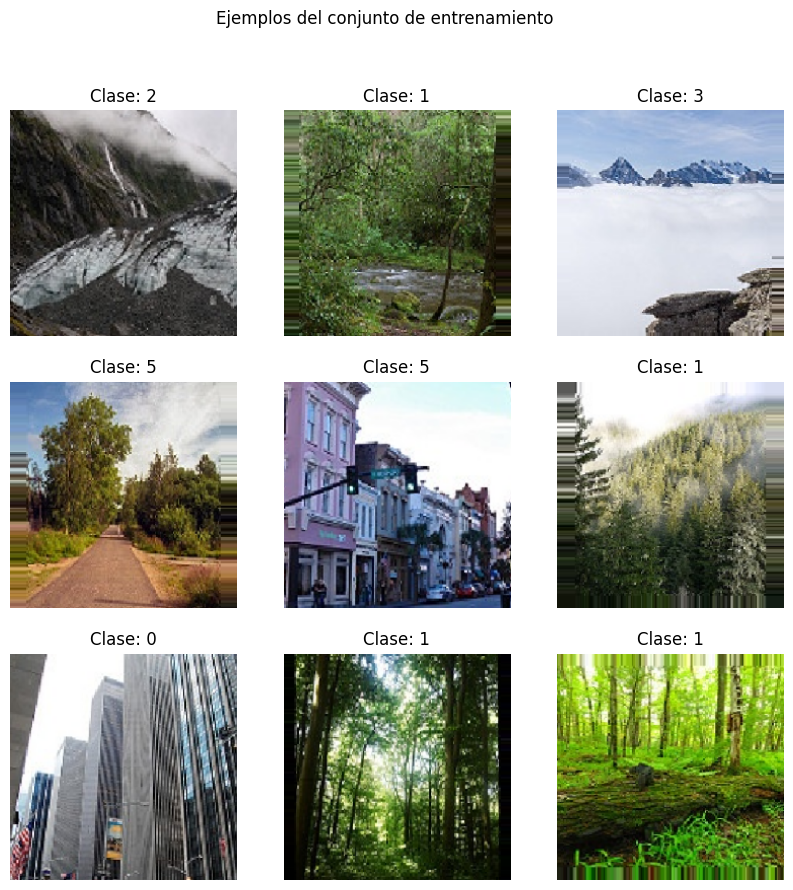

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Obtenemos un batch (lote) de imágenes y sus etiquetas
x_batch, y_batch = next(train_generator)

# Mostramos algunas imágenes
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    # Mostramos la etiqueta (convertida a número, para simplificar)
    plt.title("Clase: " + str(np.argmax(y_batch[i])))
    plt.axis("off")
plt.suptitle("Ejemplos del conjunto de entrenamiento")
plt.show()


In [16]:
# Generador para el conjunto de prueba (sin data augmentation, solo escalado)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Para evaluaciones, es mejor no mezclar el orden
)

print("Número de imágenes en el conjunto de test:", test_generator.samples)


Found 3000 images belonging to 6 classes.
Número de imágenes en el conjunto de test: 3000


In [17]:
import shutil

pred_unknown_dir = os.path.join(pred_dir, "unknown")
if not os.path.exists(pred_unknown_dir):
    os.makedirs(pred_unknown_dir)
    # Mover todas las imágenes que estén directamente en seg_pred a la subcarpeta "unknown"
    for file in os.listdir(pred_dir):
        if os.path.isfile(os.path.join(pred_dir, file)):
            shutil.move(os.path.join(pred_dir, file), os.path.join(pred_unknown_dir, file))

# Generador para el conjunto de predicción
pred_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,  # No hay etiquetas en predicción
    shuffle=False
)

print("Número de imágenes para predicción:", pred_generator.samples)


Found 7301 images belonging to 1 classes.
Número de imágenes para predicción: 7301


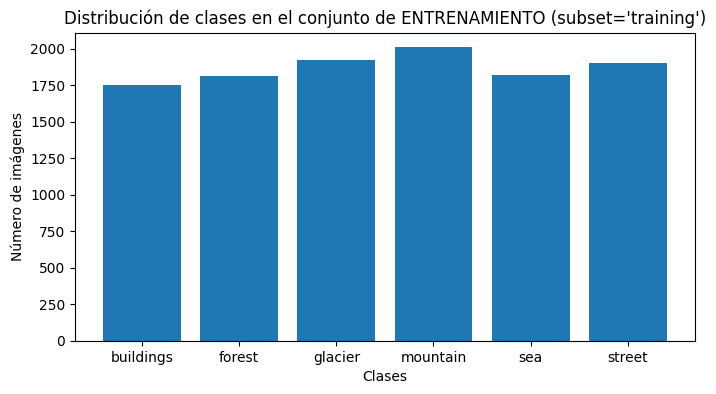

Total de imágenes en entrenamiento (subset='training'): 11230


In [19]:
# Invertimos el diccionario class_indices para obtener los nombres de clase a partir de los índices
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

# Obtenemos todas las clases (en índices numéricos) del generador de entrenamiento
train_class_indices = train_generator.classes  # array con el índice de clase de cada imagen

# Contamos cuántas imágenes hay en cada clase
unique_indices, counts = np.unique(train_class_indices, return_counts=True)

# Visualizamos en un bar plot
plt.figure(figsize=(8, 4))
plt.bar(unique_indices, counts, tick_label=[idx_to_class[i] for i in unique_indices])
plt.title("Distribución de clases en el conjunto de ENTRENAMIENTO (subset='training')")
plt.xlabel("Clases")
plt.ylabel("Número de imágenes")
plt.show()

# (Opcional) Ver cuántas hay en total
print("Total de imágenes en entrenamiento (subset='training'):", sum(counts))


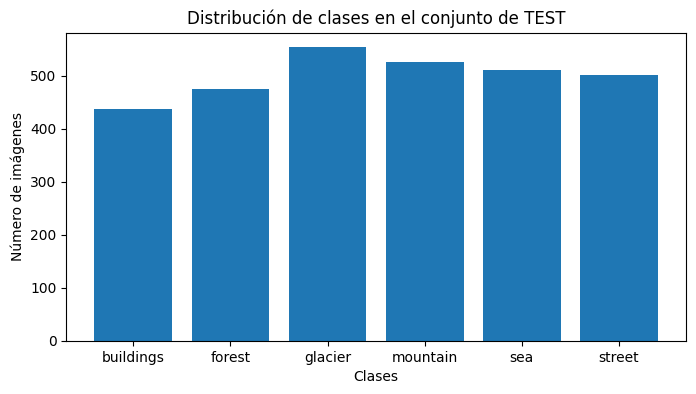

Total de imágenes en test: 3000


In [20]:
# Para el test_generator, no hay subsets, así que todas las imágenes están aquí
test_class_indices = test_generator.classes

unique_test_indices, test_counts = np.unique(test_class_indices, return_counts=True)

# Invertimos el diccionario de clases para test (mismo mapeo que en entrenamiento)
idx_to_class_test = {v: k for k, v in test_generator.class_indices.items()}

plt.figure(figsize=(8, 4))
plt.bar(unique_test_indices, test_counts, tick_label=[idx_to_class_test[i] for i in unique_test_indices])
plt.title("Distribución de clases en el conjunto de TEST")
plt.xlabel("Clases")
plt.ylabel("Número de imágenes")
plt.show()

print("Total de imágenes en test:", sum(test_counts))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model_cnn = Sequential()

# Capa convolucional 1
model_cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',
                     input_shape=(img_height, img_width, 3)))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))

# Capa convolucional 2
model_cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))

# Capa convolucional 3 (opcional)
model_cnn.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))

# Aplanado
model_cnn.add(Flatten())

# Capa densa (oculta)
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))

# Capa de salida (6 clases)
model_cnn.add(Dense(6, activation='softmax'))

# Mostramos el resumen de la arquitectura
model_cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model_cnn.compile(
    optimizer='adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
epochs = 10  # demora un poco con 10, mejor bajar a 5

history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)


Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 96s 274ms/step - accuracy: 0.4731 - loss: 1.3974 - val_accuracy: 0.6717 - val_loss: 0.8979
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5938 - loss: 1.0113 - val_accuracy: 0.6659 - val_loss: 0.9023
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 94s 268ms/step - accuracy: 0.6552 - loss: 0.9289 - val_accuracy: 0.7540 - val_loss: 0.6924
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6250 - loss: 0.9044 - val_accuracy: 0.7435 - val_loss: 0.7094
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 95s 270ms/step - accuracy: 0.7108 - loss: 0.7869 - val_accuracy: 0.7486 - val_loss: 0.7109
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 154s 440ms/step - accuracy: 0.6250 - loss: 0.8016 - val_accuracy: 0.7590 - val_loss: 0.6807
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 95s 270ms/step - accuracy: 0.7516 - loss: 0.6927 - val_accuracy: 0.7733 - val_loss: 0.6221
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6562 - loss: 0.8

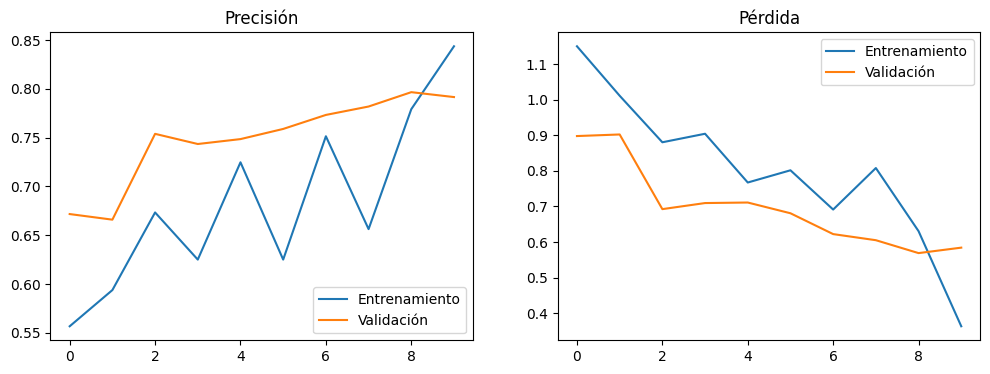

In [24]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    
    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Validación')
    plt.legend(loc='lower right')
    plt.title('Precisión')
    
    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida')
    
    plt.show()

# Llamamos a la función
plot_training_history(history_cnn)


In [25]:
test_loss, test_accuracy = model_cnn.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size,
    verbose=1
)

print("Pérdida en test:", test_loss)
print("Precisión en test:", test_accuracy)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8457 - loss: 0.4557
Pérdida en test: 0.5222145318984985
Precisión en test: 0.8155242204666138


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step
Classification Report:
              precision    recall  f1-score   support

   buildings       0.75      0.86      0.80       437
      forest       0.98      0.90      0.94       474
     glacier       0.80      0.80      0.80       553
    mountain       0.75      0.76      0.76       525
         sea       0.81      0.79      0.80       510
      street       0.82      0.78      0.80       501

    accuracy                           0.81      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.81      0.81      3000



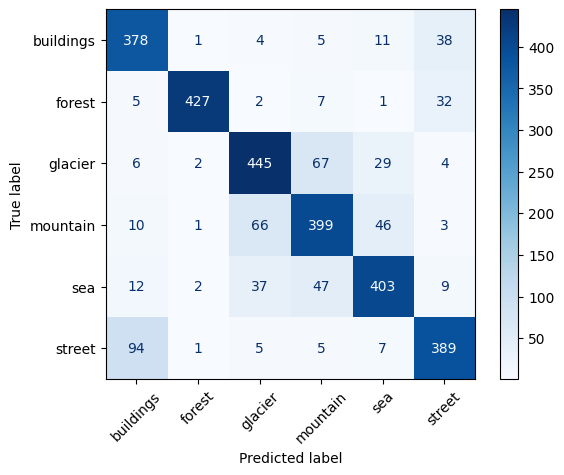

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# predecir probabilidades
y_pred_proba = model_cnn.predict(
    test_generator,
    steps=test_generator.samples // batch_size + 1
)

# convertir a índices de clase
y_pred = np.argmax(y_pred_proba, axis=1)

# etiquetas reales (índices)
y_true = test_generator.classes

# classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()


In [27]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Cargar MobileNetV2 
base_model = MobileNetV2(weights='imagenet', include_top=False, 
                         input_shape=(img_height, img_width, 3))

# Congelar el modelo base para que no se actualicen sus pesos durante el entrenamiento inicial
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)           # Convierte la salida 3D en 1D
x = Dense(128, activation='relu')(x)        # Capa densa oculta
x = Dropout(0.5)(x)                         # Dropout para reducir el overfitting
predictions = Dense(6, activation='softmax')(x)  # Capa de salida para 6 clases

# Definir el modelo completo
model_transfer = Model(inputs=base_model.input, outputs=predictions)

# Mostrar 
print("Resumen del modelo Transfer Learning:")
model_transfer.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Resumen del modelo Transfer Learning:


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compilar el modelo
model_transfer.compile(
    optimizer='adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar el modelo utilizando los generadores de entrenamiento y validación
epochs = 10  
history_transfer = model_transfer.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)


Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 111s 313ms/step - accuracy: 0.7699 - loss: 0.5981 - val_accuracy: 0.8980 - val_loss: 0.2718
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9062 - loss: 0.3366 - val_accuracy: 0.8937 - val_loss: 0.2853
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 97s 276ms/step - accuracy: 0.8750 - loss: 0.3379 - val_accuracy: 0.9005 - val_loss: 0.2670
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9375 - loss: 0.2474 - val_accuracy: 0.9034 - val_loss: 0.2633
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 97s 276ms/step - accuracy: 0.8894 - loss: 0.2875 - val_accuracy: 0.9012 - val_loss: 0.2607
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8750 - loss: 0.3663 - val_accuracy: 0.9070 - val_loss: 0.2712
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 131s 373ms/step - accuracy: 0.8969 - loss: 0.2774 - val_accuracy: 0.9041 - val_loss: 0.2690
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9375 - loss: 0.1

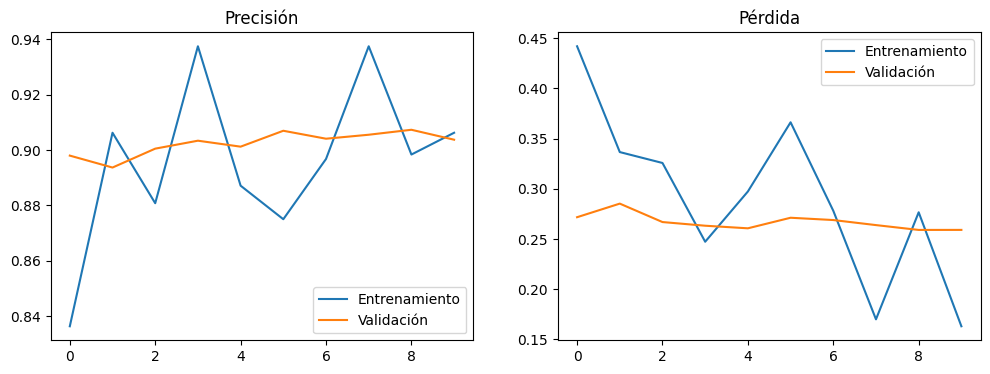

In [29]:
# Función para graficar el historial de entrenamiento
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    
    # Gráfica de precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Validación')
    plt.legend(loc='lower right')
    plt.title('Precisión')
    
    # Gráfica de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida')
    
    plt.show()

# Visualizar el historial de entrenamiento
plot_training_history(history_transfer)


In [ ]:
# Evaluar el modelo
test_loss, test_accuracy = model_transfer.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size,
    verbose=1
)

print("Pérdida en test (Transfer Learning):", test_loss)
print("Precisión en test (Transfer Learning):", test_accuracy)


93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.9208 - loss: 0.2063
Pérdida en test (Transfer Learning): 0.23688265681266785
Precisión en test (Transfer Learning): 0.9092742204666138


94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step
Classification Report (Transfer Learning):
              precision    recall  f1-score   support

   buildings       0.92      0.92      0.92       437
      forest       0.99      0.99      0.99       474
     glacier       0.82      0.87      0.84       553
    mountain       0.89      0.80      0.84       525
         sea       0.93      0.96      0.95       510
      street       0.93      0.93      0.93       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



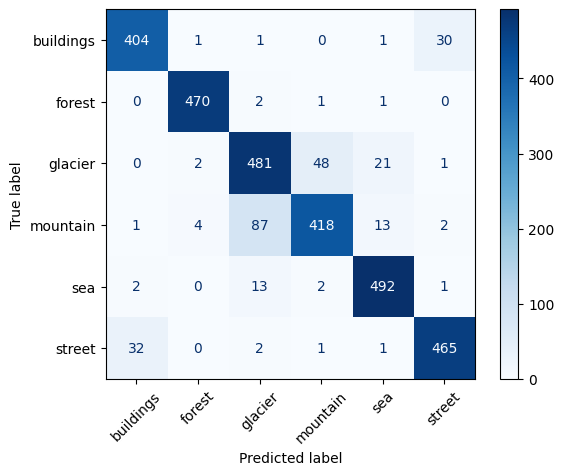

In [31]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Predecir probabilidades para cada imagen en el conjunto de test
y_pred_proba = model_transfer.predict(
    test_generator,
    steps=test_generator.samples // batch_size + 1
)

# Convertir las probabilidades en índices de clase
y_pred = np.argmax(y_pred_proba, axis=1)

# Etiquetas reales (índices) extraídos del generador
y_true = test_generator.classes

# Imprimir el classification report
print("Classification Report (Transfer Learning):")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()


In [33]:
# Fine Tuning 

# Número de capas totales del modelo base
print("Total de capas en el modelo base:", len(base_model.layers))

# Definir cuántas capas se descongelan (por ejemplo, 30)
fine_tune_at = len(base_model.layers) - 30

# Descongelar todo el modelo base
base_model.trainable = True

# Volver a congelar las capas anteriores a fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print("Capas entrenables a partir de la capa:", fine_tune_at)


Total de capas en el modelo base: 154
Capas entrenables a partir de la capa: 124


In [34]:
from tensorflow.keras.optimizers import Adam

model_transfer.compile(
    optimizer=Adam(learning_rate=1e-5),  # Learning rate reducido
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [35]:
fine_tune_epochs = 10  

history_fine = model_transfer.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=fine_tune_epochs
)


Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 119s 329ms/step - accuracy: 0.7857 - loss: 0.6850 - val_accuracy: 0.9034 - val_loss: 0.2811
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8750 - loss: 0.2100 - val_accuracy: 0.9142 - val_loss: 0.2652
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 107s 306ms/step - accuracy: 0.8730 - loss: 0.3491 - val_accuracy: 0.9145 - val_loss: 0.2611
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8750 - loss: 0.3292 - val_accuracy: 0.9134 - val_loss: 0.2662
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 109s 312ms/step - accuracy: 0.8850 - loss: 0.3213 - val_accuracy: 0.9102 - val_loss: 0.2605
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9375 - loss: 0.1243 - val_accuracy: 0.9127 - val_loss: 0.2667
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 107s 306ms/step - accuracy: 0.9017 - loss: 0.2715 - val_accuracy: 0.9145 - val_loss: 0.2573
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8438 - loss: 0

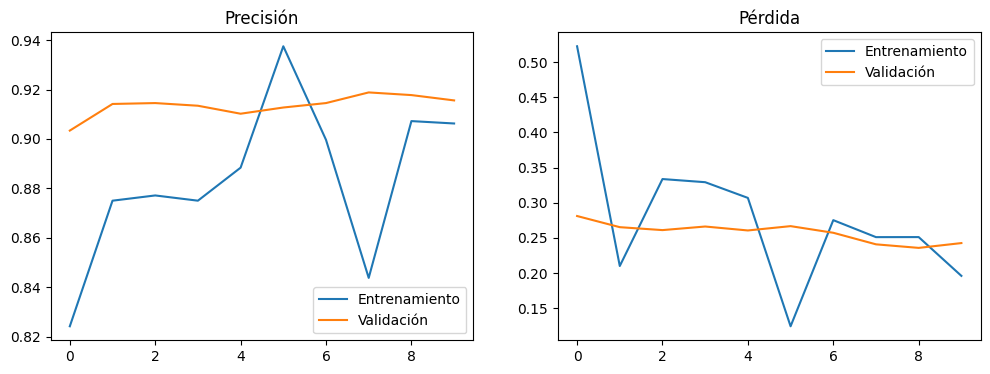

In [36]:
plot_training_history(history_fine)


In [37]:
test_loss_ft, test_accuracy_ft = model_transfer.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size,
    verbose=1
)

print("Pérdida en test (Fine-Tuning):", test_loss_ft)
print("Precisión en test (Fine-Tuning):", test_accuracy_ft)


93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.9265 - loss: 0.2018
Pérdida en test (Fine-Tuning): 0.23318782448768616
Precisión en test (Fine-Tuning): 0.9166666865348816


94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step
Classification Report (Fine-Tuning):
              precision    recall  f1-score   support

   buildings       0.92      0.94      0.93       437
      forest       0.98      0.99      0.99       474
     glacier       0.87      0.84      0.86       553
    mountain       0.87      0.85      0.86       525
         sea       0.92      0.98      0.95       510
      street       0.95      0.93      0.94       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



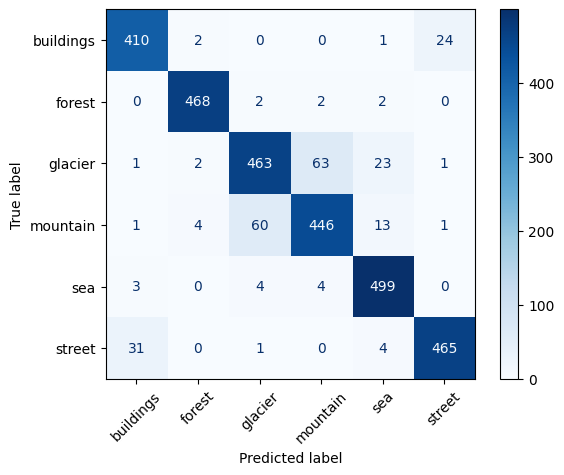

In [38]:
y_pred_proba_ft = model_transfer.predict(
    test_generator,
    steps=test_generator.samples // batch_size + 1
)
y_pred_ft = np.argmax(y_pred_proba_ft, axis=1)
y_true = test_generator.classes

print("Classification Report (Fine-Tuning):")
print(classification_report(y_true, y_pred_ft, target_names=test_generator.class_indices.keys()))

cm_ft = confusion_matrix(y_true, y_pred_ft)
disp_ft = ConfusionMatrixDisplay(confusion_matrix=cm_ft, display_labels=test_generator.class_indices.keys())
disp_ft.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()


- CNN Ad-Hoc: ~81%
- Transfer Learning: ~90.9%
- Fine-Tuning: ~91.7%

- Eficiencia: Transfer Learning no solo ofrece mayor precisión, sino que generalmente requiere menos tiempo para converger (porque la mayor parte de la red ya está entrenada). con Fine Turing el tiempo es mucho mayor y es poca diferencia. 


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


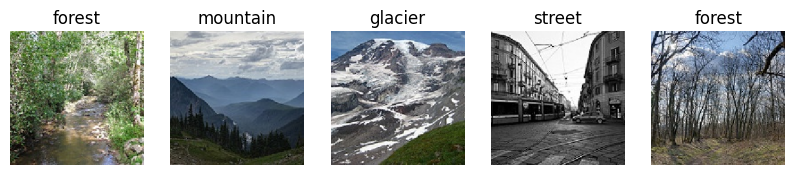

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

pred_batch = next(pred_generator)  

predictions = model_transfer.predict(pred_batch)
predicted_classes = np.argmax(predictions, axis=1)

# Mapeo índice->clase
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

plt.figure(figsize=(10, 5))
for i in range(5):  # Muestra 5 imágenes
    plt.subplot(1, 5, i+1)
    plt.imshow(pred_batch[i])
    class_index = predicted_classes[i]
    plt.title(idx_to_class[class_index])
    plt.axis('off')
plt.show()
